In [2]:
from glob import glob
import json

import pandas as pd
import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

In [3]:
def liaoetal(df, indep_vars, dep_var):
    df = df.copy()
    y = df[dep_var]
    X = df[indep_vars]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    vars = []
    for var in X.columns:
        if var != 'const' and model.pvalues.loc[var] <= 0.05:
            vars.append(var)

    medians = X.median()

    X_test = []
    for var in vars:
        x = medians.copy()
        x.loc[var] = x.loc[var]*1.1
        X_test.append(x)

    X_test = pd.DataFrame(X_test, columns=X.columns)
    results = pd.DataFrame(data={'pred': model.predict(X_test), 'var': vars})
    results['pred'] -= model.predict([medians])[0]
    results = results[results['pred'] > 0]

    #print('Ranking independent variables:')
    results.sort_values(by='pred', ascending=False, inplace=True)
    return results

In [12]:
def corrplot(casestudy):
    datapath = '../datasets/{}/workload'.format(casestudy)
    exp = pd.read_csv(datapath + '/experiments.csv', header=None, delimiter=';')
    from_, to = exp.iloc[0, [1, 2]]

    with open('../results/{}/workload.json'.format(casestudy)) as f:
        delag_res = json.load(f)

        
    for frontend in delag_res.keys():
        r_list = []
        print("Request class:", frontend)
        path = "{}/{}__{}_{}.parquet".format(datapath, frontend, from_, to)
        df = pd.read_parquet(path)
        rpcs =  [c for c in df.columns if c!="traceId" and c!="experiment" and  c!=frontend]
        res = liaoetal(df, rpcs, frontend)
        for rpc in res.iloc[:5]['var']:
            r, p = pearsonr(df[rpc], df[frontend])
            print("Pearson r of RPC {}: {} ".format(rpc, r))
            r_list.append(r)
            sns.scatterplot(data=df, x=rpc, y=frontend)
            plt.show()
        delag_rpcs = {rpc for pat in delag_res[frontend] for rpc, _, _ in pat}
        print("Intersection with DeLag", delag_rpcs & set(res.iloc[:5]['var']))
        print('\n' + '-'*60 + '\n')

    return df


Request class: ts-travel-service_queryInfo
Pearson r of RPC ts-seat-service_getLeftTicketOfInterval: 0.9817562235974514 


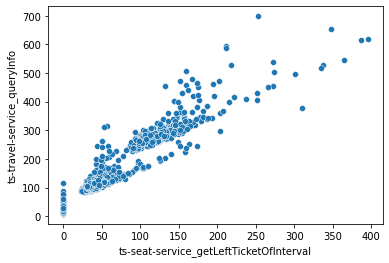

Pearson r of RPC ts-ticketinfo-service_queryForStationId: 0.9626964817977293 


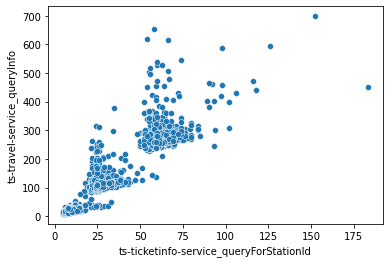

Pearson r of RPC ts-ticketinfo-service_queryForTravel: 0.9640096287904786 


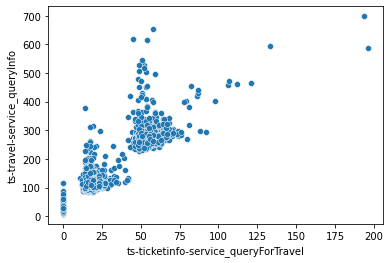

Pearson r of RPC ts-route-service_queryById: 0.9124689205222523 


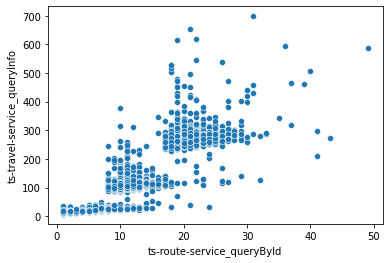

Intersection with DeLag {'ts-ticketinfo-service_queryForTravel'}

------------------------------------------------------------

Request class: ts-travel-plan-service_getByCheapest
Pearson r of RPC ts-route-plan-service_getCheapestRoutes: 0.9951272993457959 


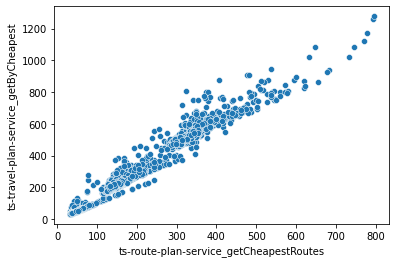

Pearson r of RPC ts-seat-service_getLeftTicketOfInterval: 0.9866614624385679 


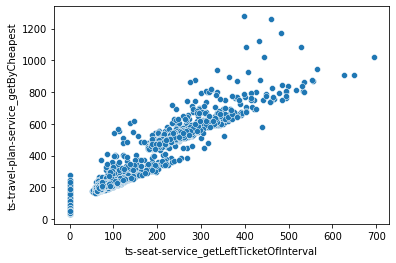

Pearson r of RPC ts-ticketinfo-service_queryForStationId: 0.9745441853780182 


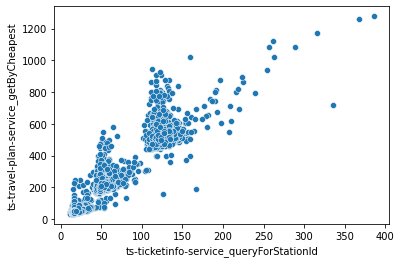

Pearson r of RPC ts-route-service_queryById: 0.9457054702487382 


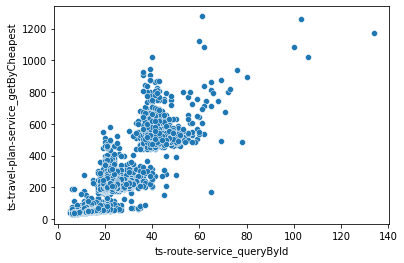

Pearson r of RPC ts-ticketinfo-service_queryForTravel: 0.9705493645532635 


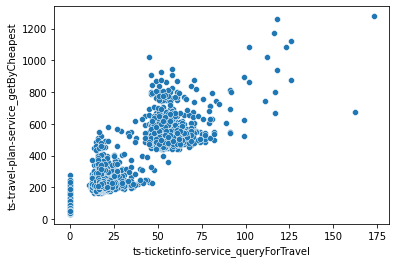

Intersection with DeLag {'ts-ticketinfo-service_queryForStationId', 'ts-ticketinfo-service_queryForTravel'}

------------------------------------------------------------

Request class: ts-preserve-service_preserve
Pearson r of RPC ts-travel-service_getTripAllDetailInfo: 0.9837690389595984 


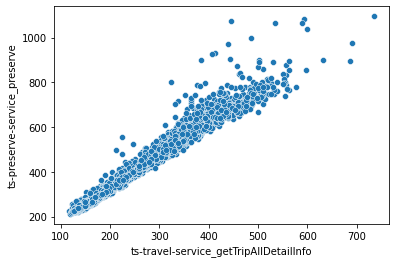

Pearson r of RPC ts-seat-service_create: 0.9390339462295274 


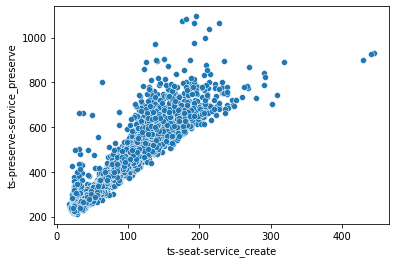

Pearson r of RPC ts-ticketinfo-service_queryForTravel: -0.10494249388236762 


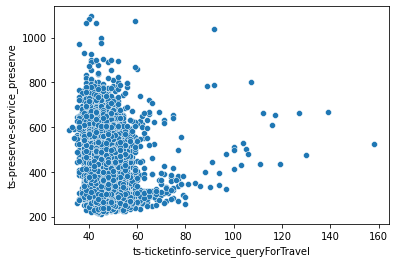

Pearson r of RPC ts-seat-service_getLeftTicketOfInterval: 0.9741525586650768 


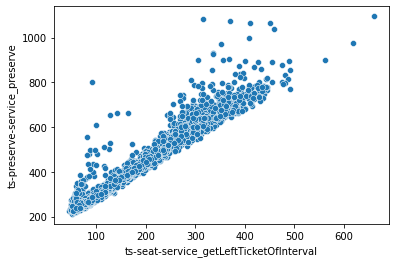

Pearson r of RPC ts-security-service_check: 0.24742492236223 


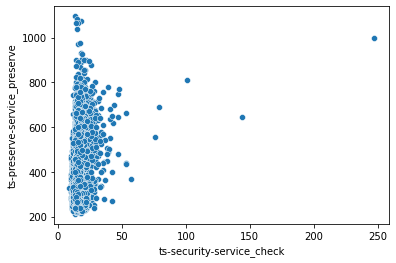

Intersection with DeLag {'ts-travel-service_getTripAllDetailInfo'}

------------------------------------------------------------

Request class: HomeControllerHome
Pearson r of RPC get: 0.5615141909729326 


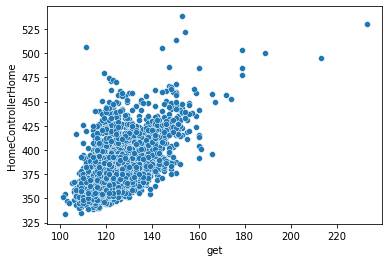

Pearson r of RPC CategoriesControllerGetcategory: 0.2932958543409696 


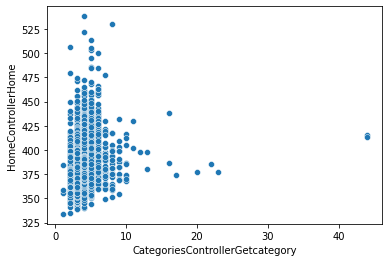

Pearson r of RPC ProductsControllerFindproductrandom: 0.1693190645565598 


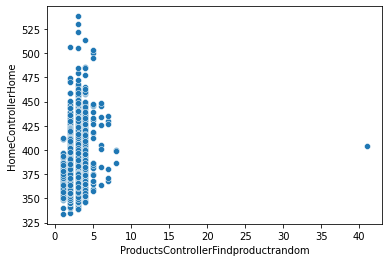

Pearson r of RPC ProductsControllerFindproduct: 0.17184640173044569 


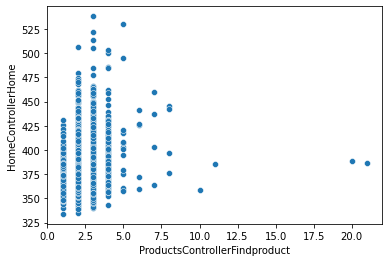

Intersection with DeLag {'get', 'ProductsControllerFindproduct'}

------------------------------------------------------------



In [13]:
for cs in ['trainticket', 'eshopper']:
    df = corrplot(cs)